# Imports

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import ticker
import pprint

# Beginning to 1929 = bull, 1929-1949 = bear, 1949-1969 = bull, 1969-1982 = bear etc.
secular_cutoff_dates = ["1929-10-01", "1949-06-01", "1969-05-01", "1982-08-02", "2000-03-01", "2011-09-01"]
first_secular_change = secular_cutoff_dates[0]
last_secular_change = secular_cutoff_dates[len(secular_cutoff_dates)-1]
# secular_bear_days = len(snp_df[secular_cutoff_dates[0]:secular_cutoff_dates[1]] +
#                         snp_df[secular_cutoff_dates[2]:secular_cutoff_dates[3]] + 
#                         snp_df[secular_cutoff_dates[4]:secular_cutoff_dates[5]])
# secular_bull_days = len(snp_df[secular_cutoff_dates[1]:secular_cutoff_dates[2]] +
#                         snp_df[secular_cutoff_dates[3]:secular_cutoff_dates[4]])
# print("Secular bear: {}\nSecular Bull: {}".format(secular_bear_days, secular_bull_days))

%matplotlib inline

# Bring in and clean up data

I bring in the data, convert the data types and column names into something a little more convenient to work with, and take a quick look at the data to ensure what we're pulling in looks correct.

In [5]:
snp_df = pd.read_excel('data.xlsx', "Sheet1")
snp_df["Date"]=pd.to_datetime(snp_df["Date"])
snp_df = snp_df.rename(columns={'PX_LAST':'Value'})
snp_df = snp_df.set_index("Date")
snp_df.head()

Value
Date             
1928-01-03  17.76
1928-01-04  17.72
1928-01-05  17.55
1928-01-06  17.66
1928-01-09  17.50

# A quick look at the data

S&P 500 ticker values are plotted twice: one a direct plot and another on a logarithmic scale. I know what these plots are supposed to look like, so this serves as another check that the data has been brought in correctly.

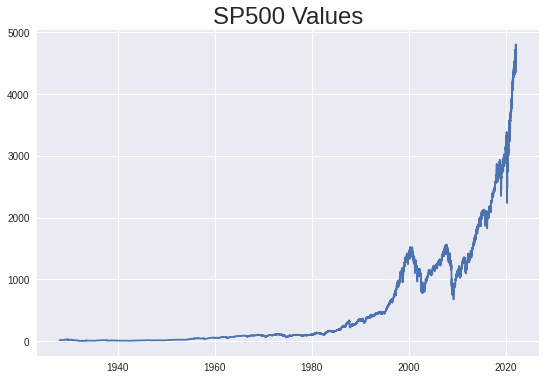

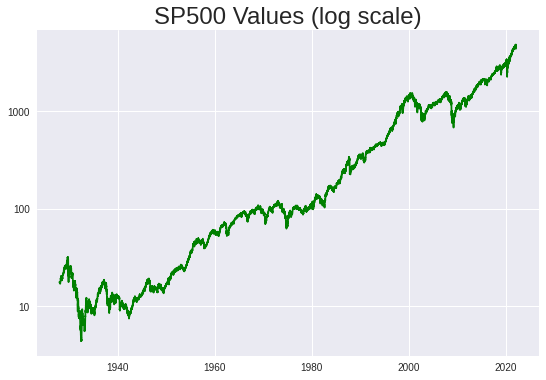

In [6]:
plt.figure(figsize=(9,6));
plt.style.use("seaborn")
plt.title("SP500 Values", fontsize=24)
plt.plot(snp_df.index.values, snp_df.Value)
plt.show()
plt.figure(figsize=(9,6));
plt.yscale("log")
plt.title("SP500 Values (log scale)", fontsize=24)
ax = plt.gca()
ax.yaxis.set_major_formatter(ticker.ScalarFormatter())
plt.plot(snp_df.index.values, snp_df.Value, color="green")
plt.show()

# Function to compute extrema

Function will take in a dataframe expecting two columns: a date index and a value. It will also take in an upper threshold and a lower threshold. It will return a tuple containing two lists, one containing the dates for local maxima, and the other containing the dates for the local minima.

In [7]:
def compute_extrema(df, upper_threshold, lower_threshold):
    (ind_prior_high, prior_high) = (df.index[0], df.iloc[0,0]) 
    (ind_prior_low, prior_low) = (df.index[0], df.iloc[0,0]) 
    prior_minima = True
    maxima = []
    minima = []
    for ind in df.index:
        if prior_minima:
            if df["Value"][ind] < prior_low:
                ind_prior_low = ind
                prior_low = df["Value"][ind]
            elif df["Value"][ind] >= upper_threshold * prior_low:
                minima.append(ind_prior_low)
                prior_minima = False
                ind_prior_high = ind
                prior_high = df["Value"][ind]
        if not prior_minima:
            if df["Value"][ind] > prior_high:
                ind_prior_high = ind
                prior_high = df["Value"][ind]
            elif df["Value"][ind] <= lower_threshold * prior_high:
                maxima.append(ind_prior_high)
                prior_minima = True
                ind_prior_low = ind
                prior_low = df["Value"][ind]
    return (minima, maxima)

# Function to count and find the averages of days in a cycle

The purpose of the following function is to find the average number of days in both secular and cyclical bear-bull cycles. It also finds the number of days for the most recent cycle. It is intended to be called by the plotting function to recreate the following horizontal bar chart, with the differences being that it is based on where we select the cycles to begin and end. Secular numbers should look similar, but based on where we set the threshold cyclical numbers may be a bit different.

<img src="./Desired Chart 1.jpeg" width=1000 height=700 />

This function takes as arguments:
   1. The dataframe containing S&P 500 values and the dates for those values.
   2. Two lists: one for the dates of the cyclical minima, and one for the dates of the cyclical maxima.
   3. An optional cyclical days threshold. Any cycle that is not at least as long as the cyclical days threshold is ignored when computing averages.
   
The function will return a tuple containing the desired information in the following order:

  1. The average of the number of days in a secular bear.
  2. The average of the number of days in a secular bull.
  3. The average of the number of days of a cyclical bear within a secular bear.
  4. The average of the number of days of a cyclical bull within a secular bear.
  5. The average of the number of days of a cyclical bear within a secular bull.
  6. The average of the number of days of a cyclical bull within a secular bull.
  7. The number of days of the current secular (bull as of 2022-03-08) cycle.
  8. The number of days of the current cyclical cycle.
  9. The type (bull or bear) of the current cyclical cycle.
  
The function performs its calculations by creating a copy of the S&P500 dataframe passed to it. It adds three columns to the copy: a cyclical column, a secular column, and a combined column. The secular column is populated as either bull or bear for rows which correspond to a shift in the secular cycle as defined above in the secular_cutoff_dates list. The cyclical column is populated as either bull or bear based on the dates in the minima and maxima list arguments. Both of these columns are then forward filled. Finally, a combined column is created by concatenating the secular and cyclical columns through a hyphen. A dataframe view named zoomed is created which limits the locally copied dataframe to between the first and final secular cycle shifts. The calculation of averages is facilitated by the logic given [here](https://stackoverflow.com/questions/53542668/count-appearances-of-a-value-until-it-changes-to-another-value).

In [8]:
def count_cycle_days(snp_df, minima, maxima, cyclical_days_threshold = 15):
    local_df = snp_df.copy()
    local_df['secular'] = np.nan
    local_df['cyclical'] = np.nan
    local_df['cyclical'].iat[0] = 'bull'
    local_df['secular'].iat[0] = 'bull'
    local_df.loc[secular_cutoff_dates[::2],'secular'] = 'bear'
    local_df.loc[secular_cutoff_dates[1::2],'secular'] = 'bull'
    local_df.loc[minima, 'cyclical'] = 'bull'
    local_df.loc[maxima, 'cyclical'] = 'bear'
    local_df = local_df.ffill()
    local_df['combined'] = local_df['secular'] + "-" + local_df['cyclical']
    # Defining zoomed -- dataframe to hold the time period between the first secular change and last secular change
    # in the data.
    zoomed = local_df[first_secular_change:last_secular_change].iloc[:-1] # Get rid of the first day after last 
                                                                          # secular change
    cyclical_df = zoomed.groupby(zoomed['combined'].ne(zoomed['combined'].shift()).cumsum())['combined'].value_counts()
    secular_df = zoomed.groupby(zoomed['secular'].ne(zoomed['secular'].shift()).cumsum())['secular'].value_counts()
    secular_bear_days_mean = secular_df[secular_df.index.isin(['bear'], level=1)].mean()
    secular_bull_days_mean = secular_df[secular_df.index.isin(['bull'], level=1)].mean()
    secular_bear_cyclical_bear_mean = cyclical_df[cyclical_df.index.isin(['bear-bear'], level=1) \
                                                  & (cyclical_df >= cyclical_days_threshold)].mean()
    secular_bear_cyclical_bull_mean = cyclical_df[cyclical_df.index.isin(['bear-bull'], level=1) \
                                                  & (cyclical_df >= cyclical_days_threshold)].mean()
    secular_bull_cyclical_bear_mean = cyclical_df[cyclical_df.index.isin(['bull-bear'], level=1) \
                                                  & (cyclical_df >= cyclical_days_threshold)].mean()
    secular_bull_cyclical_bull_mean = cyclical_df[cyclical_df.index.isin(['bull-bull'], level=1) \
                                                  & (cyclical_df >= cyclical_days_threshold)].mean()
    # Get lengths of current secular and cyclical cycle
    current_secular_cycle_days = len(local_df[secular_cutoff_dates[-1]:])
    current_cyclical_cycle_days = len(local_df[max(minima[-1], maxima[-1]):])
    current_cyclical_cycle_type = 'bear' if max(minima[-1], maxima[-1]) == maxima[-1] else 'bull'
    # Add code for current secular bull and bear averages
    
    return (secular_bear_days_mean, secular_bull_days_mean, secular_bear_cyclical_bear_mean,
            secular_bear_cyclical_bull_mean, secular_bull_cyclical_bear_mean, secular_bull_cyclical_bull_mean,
            current_secular_cycle_days, current_cyclical_cycle_days, current_cyclical_cycle_type)

# Function to create plots with minima and maxima

This function takes four arguments: a dataframe with two columns (a date index and a ticker value as in the compute_extrema function), a list containing the dates of the local minima and another list containing the local maxima (both of which are returned by the compute_extrema function), and a string which serves as the subtitle for the plots this function creates. The following function creates two plots: one with direct S&P 500 ticker values, and the other with the values logarithmically scaled. Historical ticker data is plotted on those charts. Additionally, the points identified as local highs and lows by the previous function are superimposed onto the two charts, with the local minima being colored yellow and the local maxima red.

In [9]:
def create_plots(snp_df, minima, maxima, sub=""):
    plt.figure(figsize=(15,10));
    plt.style.use("seaborn")
    plt.suptitle("SP500 Values", fontsize=36, y=0.98)
    plt.title(sub, fontsize=24, y=1)
    plt.plot(snp_df.index.values, snp_df.Value)
    plt.scatter(minima, snp_df.loc[minima].Value, color="yellow", label="lows")
    plt.scatter(maxima, snp_df.loc[maxima].Value, color="red", label="highs")
    plt.legend(loc="upper left", prop={'size': 24})
    plt.show()
    print("\n\n\n")
    plt.figure(figsize=(15,10));
    plt.yscale("log")
    plt.suptitle("SP500 Values (log scale)", fontsize=36, y=0.98)
    plt.title(sub, fontsize=24)
    ax = plt.gca()
    ax.yaxis.set_major_formatter(ticker.ScalarFormatter())
    plt.plot(snp_df.index.values, snp_df.Value, color="green")
    plt.scatter(minima, snp_df.loc[minima].Value, color="yellow", label="lows")
    plt.scatter(maxima, snp_df.loc[maxima].Value, color="red", label="highs")
    plt.legend(loc="upper left", prop={'size': 24})
    plt.show()
    print("\n\n\n")
    (secular_bear_avg_days, secular_bull_avg_days, cyclical_bear_secular_bear_days, 
        cyclical_bull_secular_bear_days, cyclical_bear_secular_bull_days, cyclical_bull_secular_bull_days, 
        current_secular_days, current_cyclical_days, current_cyclical_type)=count_cycle_days(snp_df, minima, maxima)
    secular_bear_averages = [secular_bear_avg_days, cyclical_bear_secular_bear_days, 
                                                    cyclical_bull_secular_bear_days]
    secular_bull_averages = [secular_bull_avg_days, cyclical_bear_secular_bull_days, 
                                                    cyclical_bull_secular_bull_days]
    current_cyclical = [current_cyclical_days]
    current_secular = []

#    plt.figure(figsize=(18,12));
#    plt.style.use("seaborn")
#    plt.title("Time Duration of Secular and Cyclical Cycles", fontsize=36)

In [31]:
avg_days = count_cycle_days(snp_df, dates[0], dates[1])
# print(avg_days[avg_days.index.isin(['bear-bull', 'bear-bear'], level=1)])
# print(avg_days[avg_days.index.isin(['bear-bull', 'bear-bear'], level=1)].sum())
# print(avg_days[avg_days.index.isin(['bull-bull', 'bull-bear'], level=1)].sum())
print("Mean secular bear days: {}".format(avg_days[0]))
print("Mean secular bull days: {}".format(avg_days[1]))
print("Mean secular bear cyclical bear days: {}".format(avg_days[2]))
print("Mean secular bear cyclical bull days: {}".format(avg_days[3]))
print("Mean secular bull cyclical bear days: {}".format(avg_days[4]))
print("Mean secular bull cyclical bull days: {}".format(avg_days[5]))
print("Current secular cycle days: {}".format(avg_days[6]))
print("Current cyclical cycle days: {}".format(avg_days[7]))
print("Current cyclical cycle type: {}".format(avg_days[8]))


Mean secular bear days: 3717.3333333333335
Mean secular bull days: 4711.0
Mean secular bear cyclical bear days: 424.75
Mean secular bear cyclical bull days: 550.4545454545455
Mean secular bull cyclical bear days: 156.0
Mean secular bull cyclical bull days: 1437.6666666666667
Current secular cycle days: 2616
Current cyclical cycle days: 465
Current cyclical cycle type: bull


# 20% gains and 10% losses

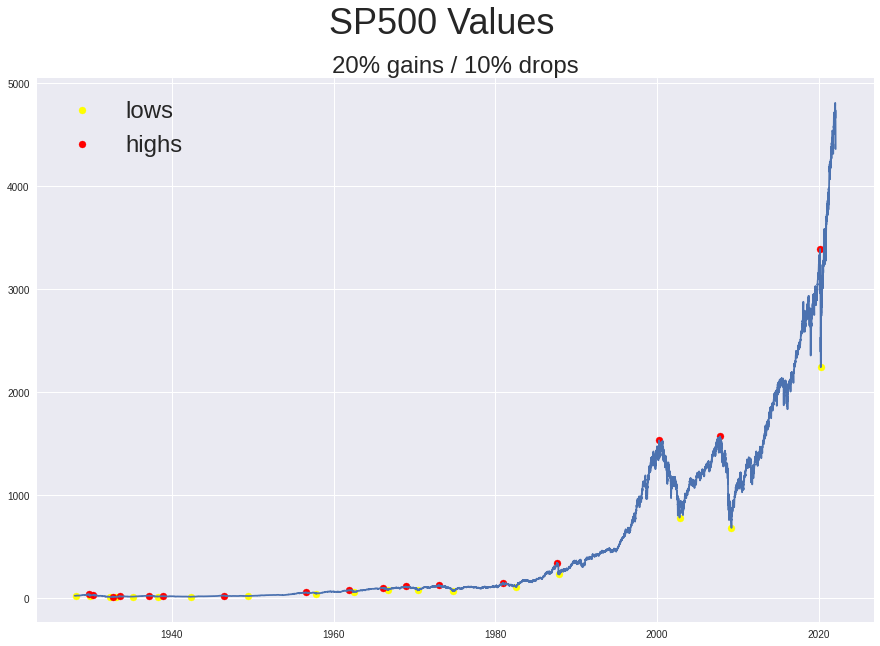

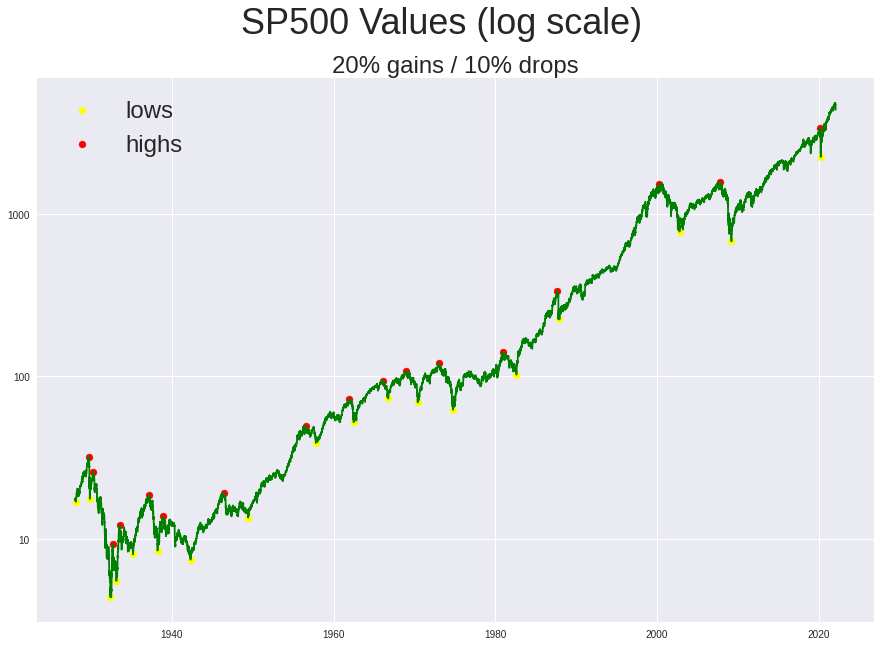

In [30]:
dates = compute_extrema(snp_df, 1.2, 0.9)
create_plots(snp_df, dates[0], dates[1], "20% gains / 10% drops")


The following is a list of days considered "minima" for the 20% gain / 10% loss scenario

In [16]:
pprint.pprint(dates[0])

[Timestamp('1928-02-20 00:00:00'),
 Timestamp('1928-06-12 00:00:00'),
 Timestamp('1929-11-13 00:00:00'),
 Timestamp('1929-12-20 00:00:00'),
 Timestamp('1930-12-16 00:00:00'),
 Timestamp('1931-06-02 00:00:00'),
 Timestamp('1931-10-05 00:00:00'),
 Timestamp('1932-06-01 00:00:00'),
 Timestamp('1933-02-27 00:00:00'),
 Timestamp('1933-03-31 00:00:00'),
 Timestamp('1933-06-15 00:00:00'),
 Timestamp('1933-10-19 00:00:00'),
 Timestamp('1935-03-14 00:00:00'),
 Timestamp('1936-04-29 00:00:00'),
 Timestamp('1938-03-31 00:00:00'),
 Timestamp('1938-05-31 00:00:00'),
 Timestamp('1938-09-27 00:00:00'),
 Timestamp('1939-04-11 00:00:00'),
 Timestamp('1940-06-10 00:00:00'),
 Timestamp('1942-04-28 00:00:00'),
 Timestamp('1943-11-29 00:00:00'),
 Timestamp('1947-05-19 00:00:00'),
 Timestamp('1949-06-13 00:00:00'),
 Timestamp('1950-07-17 00:00:00'),
 Timestamp('1953-09-14 00:00:00'),
 Timestamp('1955-10-11 00:00:00'),
 Timestamp('1957-10-22 00:00:00'),
 Timestamp('1960-10-25 00:00:00'),
 Timestamp('1962-06-

And a list of "maxima" days for the 20% gain / 10% loss scenarios

In [17]:
pprint.pprint(dates[1])

[Timestamp('1928-05-14 00:00:00'),
 Timestamp('1929-09-16 00:00:00'),
 Timestamp('1929-12-10 00:00:00'),
 Timestamp('1930-04-10 00:00:00'),
 Timestamp('1931-02-24 00:00:00'),
 Timestamp('1931-06-26 00:00:00'),
 Timestamp('1931-11-09 00:00:00'),
 Timestamp('1932-09-07 00:00:00'),
 Timestamp('1933-03-16 00:00:00'),
 Timestamp('1933-06-12 00:00:00'),
 Timestamp('1933-07-18 00:00:00'),
 Timestamp('1934-02-06 00:00:00'),
 Timestamp('1936-04-06 00:00:00'),
 Timestamp('1937-03-10 00:00:00'),
 Timestamp('1938-05-09 00:00:00'),
 Timestamp('1938-07-25 00:00:00'),
 Timestamp('1938-11-09 00:00:00'),
 Timestamp('1939-10-25 00:00:00'),
 Timestamp('1940-11-07 00:00:00'),
 Timestamp('1943-07-14 00:00:00'),
 Timestamp('1946-02-05 00:00:00'),
 Timestamp('1948-06-15 00:00:00'),
 Timestamp('1950-06-12 00:00:00'),
 Timestamp('1953-01-05 00:00:00'),
 Timestamp('1955-09-23 00:00:00'),
 Timestamp('1956-08-02 00:00:00'),
 Timestamp('1959-08-03 00:00:00'),
 Timestamp('1961-12-12 00:00:00'),
 Timestamp('1966-02-

# 10% Gain / 5% Loss Scenario

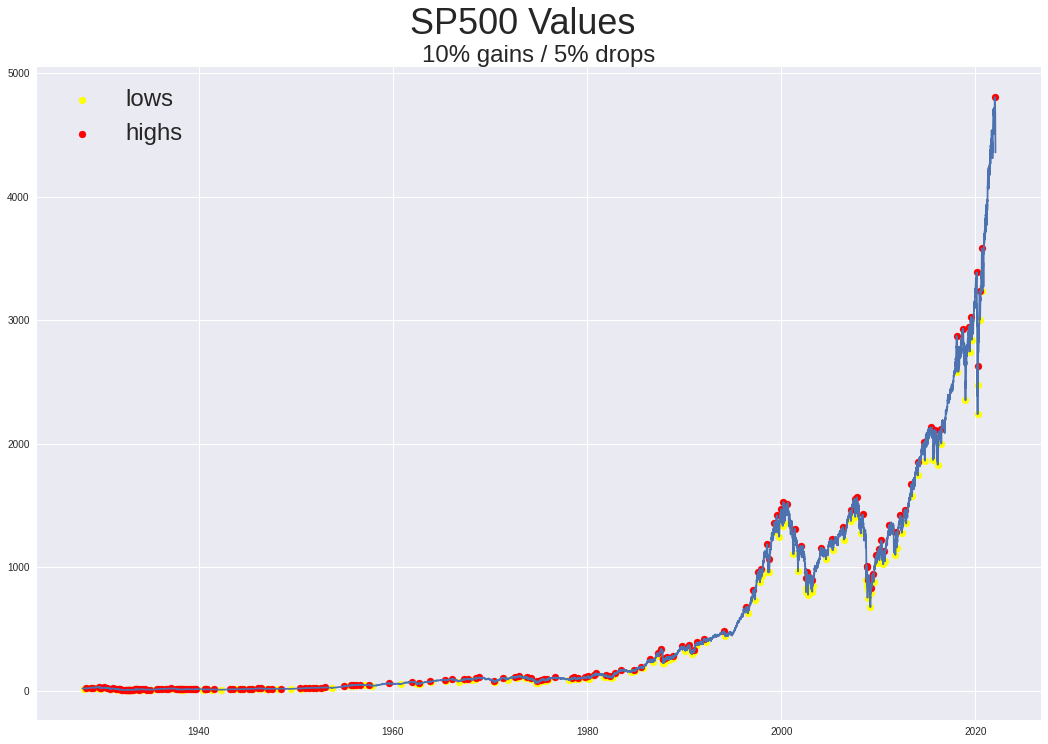

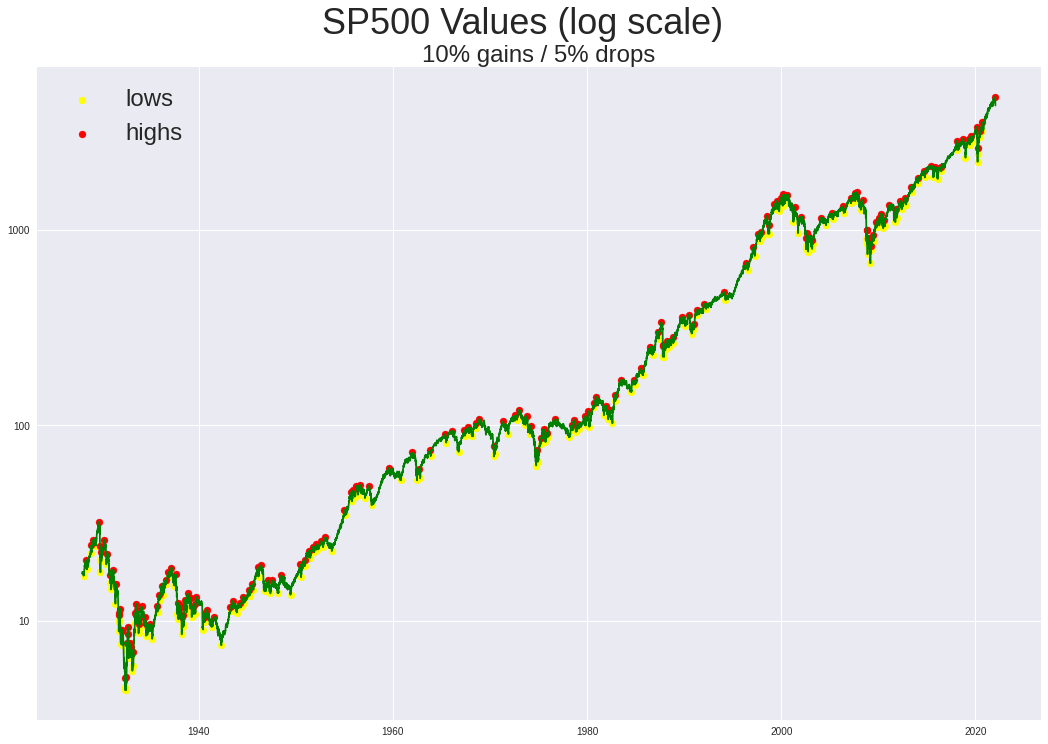

In [18]:
dates = compute_extrema(snp_df, 1.1, 0.95)
create_plots(snp_df, dates[0], dates[1], "10% gains / 5% drops")

The following is a list of days considered "minima" for the 10% gain / 5% loss scenario

In [19]:
pprint.pprint(dates[0])

[Timestamp('1928-02-20 00:00:00'),
 Timestamp('1928-06-12 00:00:00'),
 Timestamp('1928-12-10 00:00:00'),
 Timestamp('1929-05-27 00:00:00'),
 Timestamp('1929-10-29 00:00:00'),
 Timestamp('1929-11-13 00:00:00'),
 Timestamp('1929-12-20 00:00:00'),
 Timestamp('1930-06-24 00:00:00'),
 Timestamp('1930-11-10 00:00:00'),
 Timestamp('1930-12-16 00:00:00'),
 Timestamp('1931-06-02 00:00:00'),
 Timestamp('1931-10-05 00:00:00'),
 Timestamp('1931-10-14 00:00:00'),
 Timestamp('1931-10-28 00:00:00'),
 Timestamp('1932-01-05 00:00:00'),
 Timestamp('1932-02-10 00:00:00'),
 Timestamp('1932-06-01 00:00:00'),
 Timestamp('1932-06-08 00:00:00'),
 Timestamp('1932-07-08 00:00:00'),
 Timestamp('1932-08-12 00:00:00'),
 Timestamp('1932-09-19 00:00:00'),
 Timestamp('1932-10-10 00:00:00'),
 Timestamp('1932-11-03 00:00:00'),
 Timestamp('1932-12-02 00:00:00'),
 Timestamp('1932-12-22 00:00:00'),
 Timestamp('1933-02-27 00:00:00'),
 Timestamp('1933-03-31 00:00:00'),
 Timestamp('1933-06-15 00:00:00'),
 Timestamp('1933-07-

And a list of "maxima" days for the 20% gain / 5% loss scenarios

In [20]:
pprint.pprint(dates[1])

[Timestamp('1928-05-14 00:00:00'),
 Timestamp('1928-11-30 00:00:00'),
 Timestamp('1929-02-01 00:00:00'),
 Timestamp('1929-09-16 00:00:00'),
 Timestamp('1929-10-31 00:00:00'),
 Timestamp('1929-12-10 00:00:00'),
 Timestamp('1930-04-10 00:00:00'),
 Timestamp('1930-07-28 00:00:00'),
 Timestamp('1930-11-21 00:00:00'),
 Timestamp('1931-02-24 00:00:00'),
 Timestamp('1931-06-26 00:00:00'),
 Timestamp('1931-10-08 00:00:00'),
 Timestamp('1931-10-20 00:00:00'),
 Timestamp('1931-11-09 00:00:00'),
 Timestamp('1932-01-15 00:00:00'),
 Timestamp('1932-02-16 00:00:00'),
 Timestamp('1932-06-06 00:00:00'),
 Timestamp('1932-06-15 00:00:00'),
 Timestamp('1932-08-10 00:00:00'),
 Timestamp('1932-09-07 00:00:00'),
 Timestamp('1932-09-21 00:00:00'),
 Timestamp('1932-10-19 00:00:00'),
 Timestamp('1932-11-11 00:00:00'),
 Timestamp('1932-12-14 00:00:00'),
 Timestamp('1933-01-10 00:00:00'),
 Timestamp('1933-03-16 00:00:00'),
 Timestamp('1933-06-12 00:00:00'),
 Timestamp('1933-07-18 00:00:00'),
 Timestamp('1933-07-

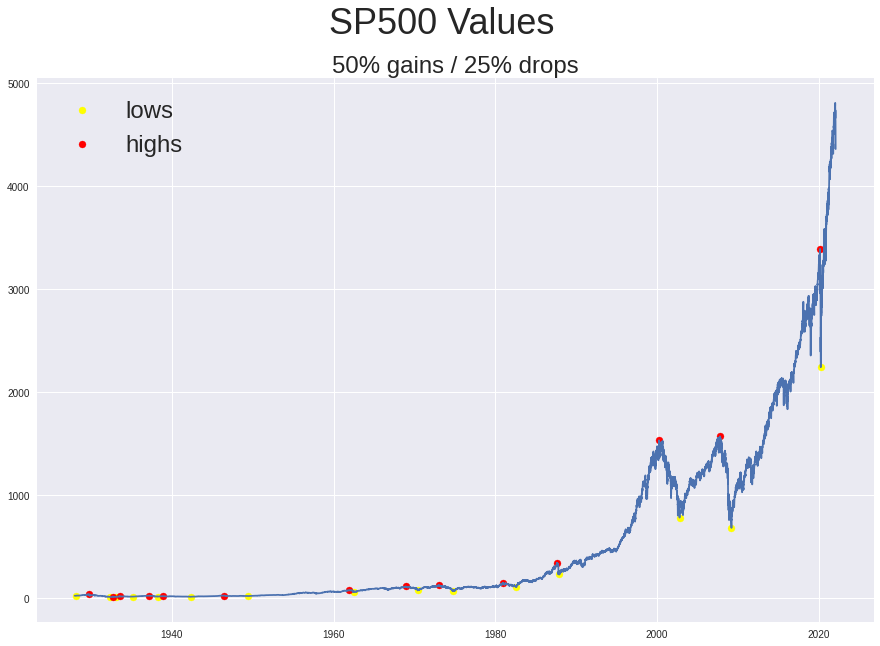

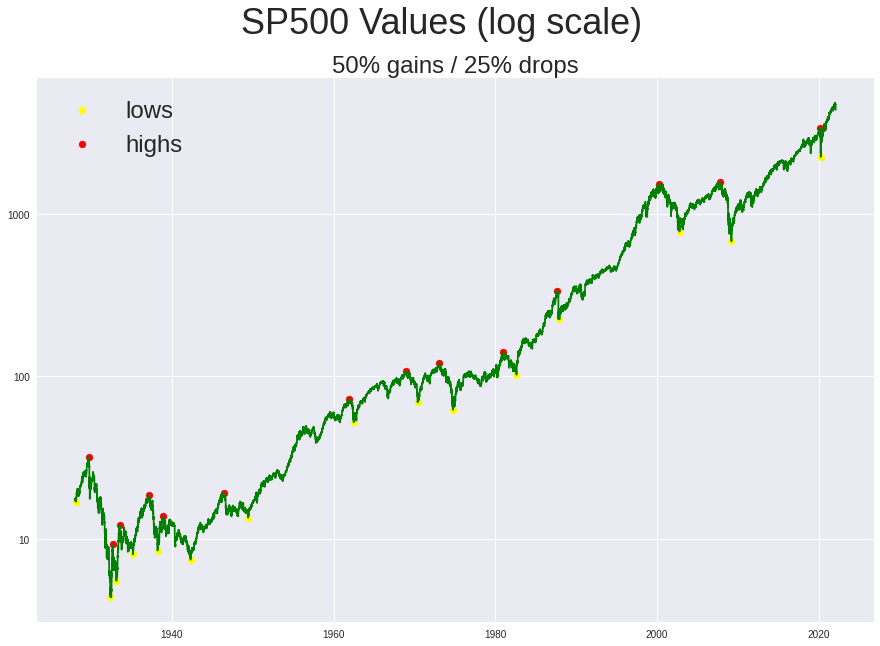

In [28]:
dates = compute_extrema(snp_df, 1.5, 0.75)
create_plots(snp_df, dates[0], dates[1], "50% gains / 25% drops")

In [24]:
pprint.pprint(dates[0])

[Timestamp('1928-02-20 00:00:00'),
 Timestamp('1932-06-01 00:00:00'),
 Timestamp('1933-02-27 00:00:00'),
 Timestamp('1935-03-14 00:00:00'),
 Timestamp('1938-03-31 00:00:00'),
 Timestamp('1942-04-28 00:00:00'),
 Timestamp('1949-06-13 00:00:00'),
 Timestamp('1962-06-26 00:00:00'),
 Timestamp('1970-05-26 00:00:00'),
 Timestamp('1974-10-03 00:00:00'),
 Timestamp('1982-08-12 00:00:00'),
 Timestamp('1987-12-04 00:00:00'),
 Timestamp('2002-10-09 00:00:00'),
 Timestamp('2009-03-09 00:00:00'),
 Timestamp('2020-03-23 00:00:00')]


In [25]:
pprint.pprint(dates[1])

[Timestamp('1929-09-16 00:00:00'),
 Timestamp('1932-09-07 00:00:00'),
 Timestamp('1933-07-18 00:00:00'),
 Timestamp('1937-03-10 00:00:00'),
 Timestamp('1938-11-09 00:00:00'),
 Timestamp('1946-05-29 00:00:00'),
 Timestamp('1961-12-12 00:00:00'),
 Timestamp('1968-11-29 00:00:00'),
 Timestamp('1973-01-11 00:00:00'),
 Timestamp('1980-11-28 00:00:00'),
 Timestamp('1987-08-25 00:00:00'),
 Timestamp('2000-03-24 00:00:00'),
 Timestamp('2007-10-09 00:00:00'),
 Timestamp('2020-02-19 00:00:00')]
